# Completed Scattered Jigsaw Puzzle
Continuing from part-2
* Assembly of scattered puzzles

In [104]:
from sklearn import *
from scipy.ndimage import filters
from PIL import Image, ImageChops,ImageOps,ImageEnhance

import matplotlib.pyplot as plt
import numpy as np
import cv2
data_dir = '/Users/haritharash/Desktop/warwick/class/Image_&_Video_Analysis/coursework/data/'

puzzle_1 = np.array(Image.open(data_dir + 'pieces-1.jpg').convert('RGB')) 
puzzle_2 = np.array(Image.open(data_dir + 'pieces-2.jpg').convert('RGB'))
puzzle_3 = np.array(Image.open(data_dir + 'pieces-3.jpg').convert('RGB'))

def showpic(image, width=10):
  plt.figure(figsize=(width, width/1000*727))
  plt.imshow(image, cmap='gray')
  plt.axis('off')
  plt.show()

def showlist(tiles, width=10,col=5):
  n_rows = np.ceil(len(tiles)/col).astype('int')
  plt.subplots(n_rows, 5, figsize=(width, width))
  for i in range(len(tiles)):
    plt.subplot(n_rows, col, i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(tiles[i])
  plt.show()
  
def showlistPuzzle(tiles, width=10):
  n_rows = np.ceil(len(tiles)/8).astype('int')
  plt.subplots(n_rows, 8, figsize=(width, width))
  for i in range(len(tiles)):
    plt.subplot(n_rows, 8, i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(tiles[i])
  plt.show()
  
def scale_contour(contours, scale):
  contours_scaled = []
  for cnt in contours:
      M = cv2.moments(cnt)
      cx = int(M['m10']/M['m00'])
      cy = int(M['m01']/M['m00'])

      cnt_norm = cnt - [cx, cy]
      cnt_scaled = cnt_norm * scale
      cnt_scaled = cnt_scaled + [cx, cy]
      cnt_scaled = cnt_scaled.astype(np.int32)
      contours_scaled.append(cnt_scaled)

  return contours_scaled


def centerPuzzle(tile,white_tile):
    resize_contour, _ = cv2.findContours(white_tile, 0, 1)
    resize_contour =resize_contour[0]
    center, (h,w), angle = cv2.minAreaRect(resize_contour)
    x, y, w, h = cv2.boundingRect(resize_contour)
    hull = cv2.convexHull(resize_contour,returnPoints=False)
    defects = cv2.convexityDefects(resize_contour,hull)
    

    defect_points = []
    for j in range(defects.shape[0]):
        s,e,f,d = defects[j,0]
        start = tuple(resize_contour[s][0])
        end = tuple(resize_contour[e][0])
        far = tuple(resize_contour[f][0])
        if d > 2000:
            defect_points.append(f)

    new_shape, new_tile,new_tile_white = np.zeros(np.array(tile).shape[:2]), np.zeros((900,900,3), 'uint8'),np.zeros((900,900), 'uint8')
    cv2.drawContours(new_shape, [resize_contour], -1, color=1, thickness=-1)
    new_shape_tile = (tile * new_shape[:,:,None])[y:y+h,x:x+w,:]
    new_tile[(900-h)//2:(900-h)//2+h,(900-w)//2:(900-w)//2+w]  = new_shape_tile
    new_center = [h//2+y, w//2+x]
    shape_white_tile = (white_tile * new_shape[:,:])[y:y+h,x:x+w]
    new_tile_white[(900-h)//2:(900-h)//2+h,(900-w)//2:(900-w)//2+w]  = shape_white_tile
  
    return new_tile,new_tile_white,new_center,resize_contour,defect_points
  
def mse(x, y):
    return np.mean(np.square(x-y))

def getColors(img, subcontour):

  subcontour = np.flip(subcontour)

  colors = []
  for n in range(len(subcontour)-3):
    (y,x) = subcontour[n]
    (y1,x1) = subcontour[n+3]
    h, w = y1 - y, x1 - x
    new_image = cv2.add(img[y-w, x+h, :3] ,img[y+w, x-h, :3])
    colors.append(new_image)

  colors = np.array(colors, 'uint8').reshape(-1,1,3)
  colors = cv2.cvtColor(colors, cv2.COLOR_RGB2HSV)
  
  return colors.reshape(-1,3)

def rotate_puzzle(tile,tile_white):
    img_versions = []
    img_white_versions = []
    img_data_orientation = []
    for angle in [0,90,180,270]:
        rotated_img= np.array(Image.fromarray(tile.copy()).rotate(angle))
        rotated_img_white= np.array(Image.fromarray(tile_white.copy()).rotate(angle))
        rotated_img,rotated_img_white,center_box,contour,defect_indices = centerPuzzle(rotated_img,rotated_img_white)
        lock = inner_out_lock_orientations(contour,defect_indices,center_box,rotated_img)
        img_versions.append(rotated_img)
        img_white_versions.append(rotated_img_white)
        img_data_orientation.append(lock)
    return img_versions,img_white_versions,img_data_orientation
  
def data_packaging(coordinate,center,type,contour_cut):
  locks = {}
  # take the biggest difference as  reference
  xd = abs(coordinate[0] - center[0])
  yd= abs(coordinate[1] - center[1])
  if( coordinate[0] < center[0] and xd > yd):
    locks = { 
                      'type':type,
                      'coordinate': coordinate,
                      'center':center,
                      'colour':contour_cut,
                      'pos':'LEFT'
                    }
  elif( coordinate[0] > center[0] and xd > yd):
    locks = { 
                      'type':type,
                      'coordinate': coordinate,
                      'center':center,
                      'colour':contour_cut,
                      'pos':'RIGHT'
                    }
  elif( yd > xd and coordinate[1] > center[1]):
    locks = { 
                      'type':type,
                      'coordinate': coordinate,
                      'center':center,
                      'colour':contour_cut,
                      'pos': 'BOTTOM'
                  }
  elif( yd > xd  and coordinate[1] < center[1]):
    locks ={ 
                      'type':type,
                      'coordinate': coordinate,
                      'center':center,
                      'colour':contour_cut,
                      'pos': 'TOP'
                    }
  return locks

def colour_contour_edges(coord,contour,EDGE_LENGTH=350):
    start = coord - EDGE_LENGTH
    end = coord + EDGE_LENGTH
    if( abs(end-start) >  EDGE_LENGTH*2):
      end = end -1
    contour_cut = contour[start : end]
    if end > len(contour)-1:
      contour_cut =  np.append(contour[start:],contour[:end - (len(contour))],0)
    elif start < 0:
      contour_cut = np.append(contour[start:],contour[:end],0)
    return contour_cut

def inner_out_lock_orientations(contour,defect_indices,center_box,tile):
    data_locks = []
    outer_locks = []
    inner_locks = defect_indices.copy()
    for index in range(len(defect_indices)):
        start_index = int(defect_indices[index])
        if(index == len(defect_indices)-1):
            end_index = int(defect_indices[0])
        else:      
            end_index = int(defect_indices[index+1])
        if(start_index > end_index):
            from_zero = contour[:end_index]
            contour_cutted = np.append(contour[start_index :int(len(contour)-1)],from_zero,0)
            center = int(len(contour_cutted)//2) +start_index
            if(center > len(contour)-1):
                center= center - (len(contour)-1)
        elif(start_index < end_index):
            contour_cutted = contour[start_index :end_index]
            center = int((start_index+ end_index)//2)
        # print(f"{start_index} - > {end_index}")
        # print(f"center {center} last index {len(contour)-1}")
        area = cv2.contourArea(contour_cutted)
        # cv2.drawContours(tile,[contour_cutted],-1,0,thickness=cv2.FILLED)
        # print(" Area ",area)
        if area < 25000:
            # cv2.drawContours(tile,[contour_cutted],-1,0,thickness=cv2.FILLED)
            center_coord = contour[center][0]
            outer_locks.append(center)
            if start_index in inner_locks: inner_locks.remove(start_index)
            if end_index in inner_locks: inner_locks.remove(end_index)
    for inner in inner_locks:
        coord_inner = contour[inner][0]
        contour_cut = colour_contour_edges(inner,contour)
        # cv2.circle(tile,coord_inner,5,[255,0,0],30)
        # cv2.drawContours(tile,contour_cut,-1,[255,0,0],10)
        data_locks.append(data_packaging(coord_inner,center_box,'INNER',contour_cut))

    for outer in outer_locks:
        coord_outer = contour[outer][0]
        contour_cut = colour_contour_edges(outer,contour)
        # cv2.circle(tile,coord_outer,5,[0,255,0],30)
        # cv2.drawContours(tile,contour_cut,-1,[0,0,255],10)
        data_locks.append(data_packaging(coord_outer,center_box,'OUTER',contour_cut))
    # print(outer_locks)
    # print(inner_locks)
    # print(center_box)
    # print(f"LOCK: ",data_locks)

    return data_locks

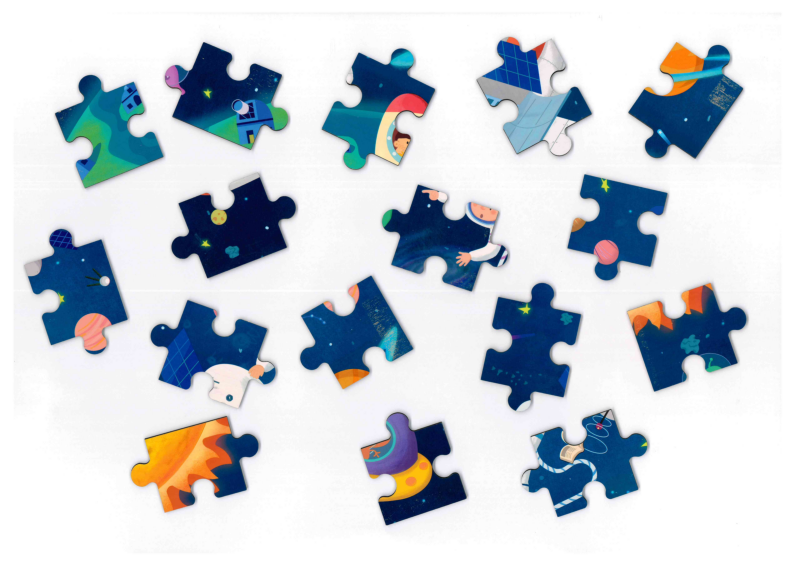

/var/folders/8r/7rhpzt7n08d24pwrzj7xcj7c0000gn/T/ipykernel_1667/2530427285.py:29: DeprecationWarning: Please use `median_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smooth = filters.median_filter(fill_2.astype('uint8'), size=10)


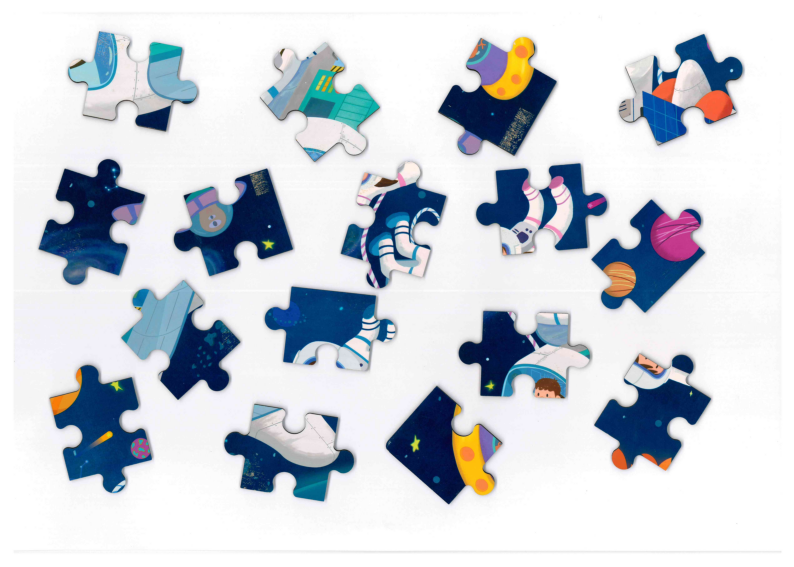

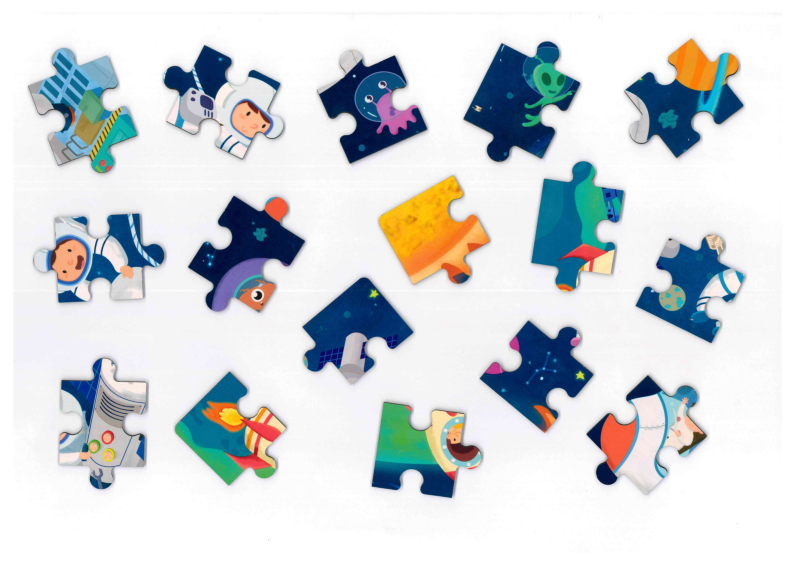

/var/folders/8r/7rhpzt7n08d24pwrzj7xcj7c0000gn/T/ipykernel_1667/925205940.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_rows, col, i+1)


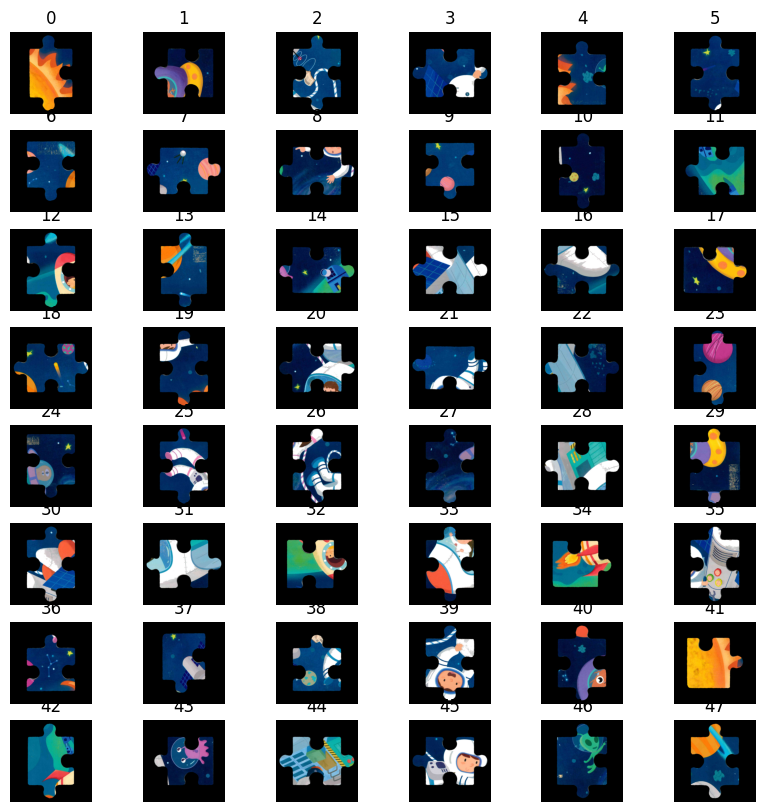

In [105]:
THICKNESS_CROPPED = 35
EDGE_LENGTH = 350
PIXEL = 240
PERCENT = 0.976

ref = np.array([255, 255, 255])
#find the best separatin pixel

puzzles = [puzzle_1,puzzle_2,puzzle_3]
tiles, tile_centers,tiles_white = [], [], []
for puzzle in puzzles:
  showpic(puzzle)
  white = 3 * np.square(255) - np.sum(np.square(puzzle- ref),axis=2)
  condition = white > np.max(white)*0.976
  puzzle[condition] = 255

  gray = cv2.cvtColor(puzzle, cv2.COLOR_RGB2GRAY)
  img = cv2.GaussianBlur(gray,(7,7),1)
  ret,th3 = cv2.threshold(img,240,255,cv2.THRESH_BINARY_INV)
  th3= cv2.GaussianBlur(th3,(7,7),1)

  contours,_ = cv2.findContours(th3,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

  sorting = sorted([[cnt.shape[0],i]for i,cnt in enumerate(contours)],reverse=True)[:16]
  biggest_2 = [contours[s[1]] for s in sorting]
  biggest_2 = scale_contour(biggest_2,0.99)
  fill_2 = cv2.drawContours(np.zeros(puzzle.shape[:2]),biggest_2,-1,1,cv2.FILLED)

  smooth = filters.median_filter(fill_2.astype('uint8'), size=10)
  trim_contours, _ = cv2.findContours(smooth, 0, 1)
  edges= cv2.drawContours(np.zeros(smooth.shape[:2]), trim_contours, -1, (255,255,255), thickness=THICKNESS_CROPPED)
  smooth = cv2.drawContours(np.zeros(smooth.shape[:2]), trim_contours, -1, 1, thickness=cv2.FILLED)
  # test = cv2.drawContours(puzzle.copy(),trim_contours,-1,(0,255,0),THICKNESS_CROPPED)

  indexes = np.where(edges == 255)
  smooth[indexes] = 0

    
  contours_tiles, _ = cv2.findContours(smooth.astype(np.uint8), 0, 1)
  for i in range(len(contours_tiles)):
      c, (h,w), angle = cv2.minAreaRect(contours_tiles[i])
      x, y, w, h = cv2.boundingRect(contours_tiles[i])
      shape, tile,tile_white = np.zeros(smooth.shape[:2]), np.zeros((900,900,3), 'uint8'),np.zeros((900,900), 'uint8')
      cv2.drawContours(shape, [contours_tiles[i]], -1, color=1, thickness=-1)
      shape_tile = (puzzle * shape[:,:,None])[y:y+h,x:x+w,:]
      tile[(900-h)//2:(900-h)//2+h,(900-w)//2:(900-w)//2+w]  = shape_tile
      shape_white_tile = (smooth * shape[:,:])[y:y+h,x:x+w]
      tile_white[(900-h)//2:(900-h)//2+h,(900-w)//2:(900-w)//2+w]  = shape_white_tile
      rotated_tile = np.array(Image.fromarray(tile.copy()).rotate(angle))
      rotated_white_tile = np.array(Image.fromarray(tile_white.copy()).rotate(angle))
      tile,tile_white,center,a,b = centerPuzzle(rotated_tile,rotated_white_tile)
      tiles.append(tile)
      tile_centers.append(center)
      tiles_white.append(tile_white)


showlist(tiles,col=6)

# Classification

/var/folders/8r/7rhpzt7n08d24pwrzj7xcj7c0000gn/T/ipykernel_1667/925205940.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_rows, col, i+1)


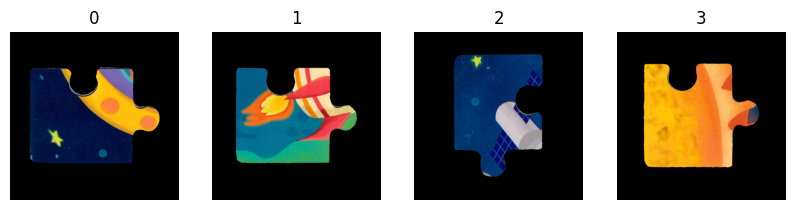

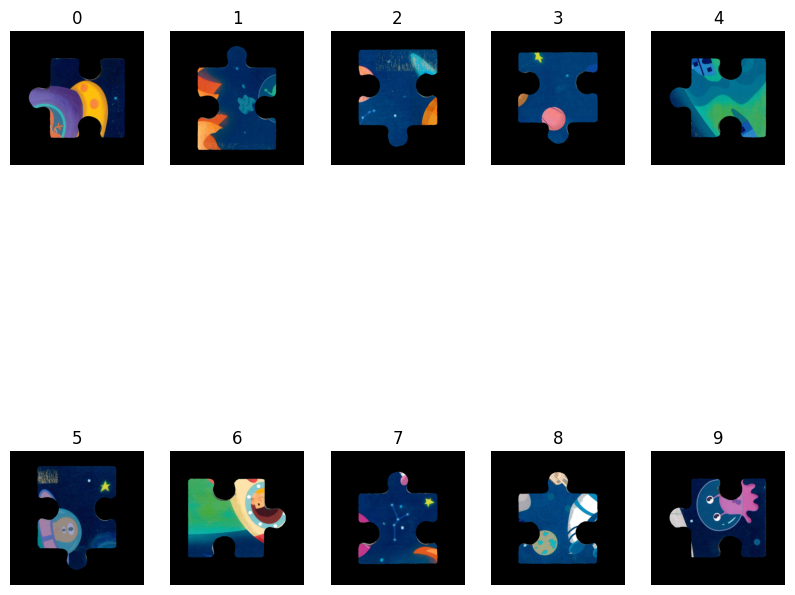

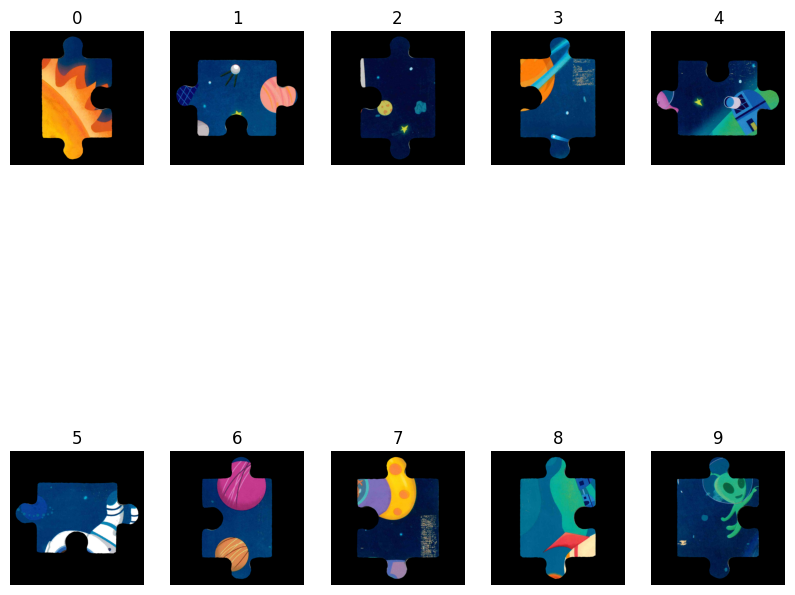

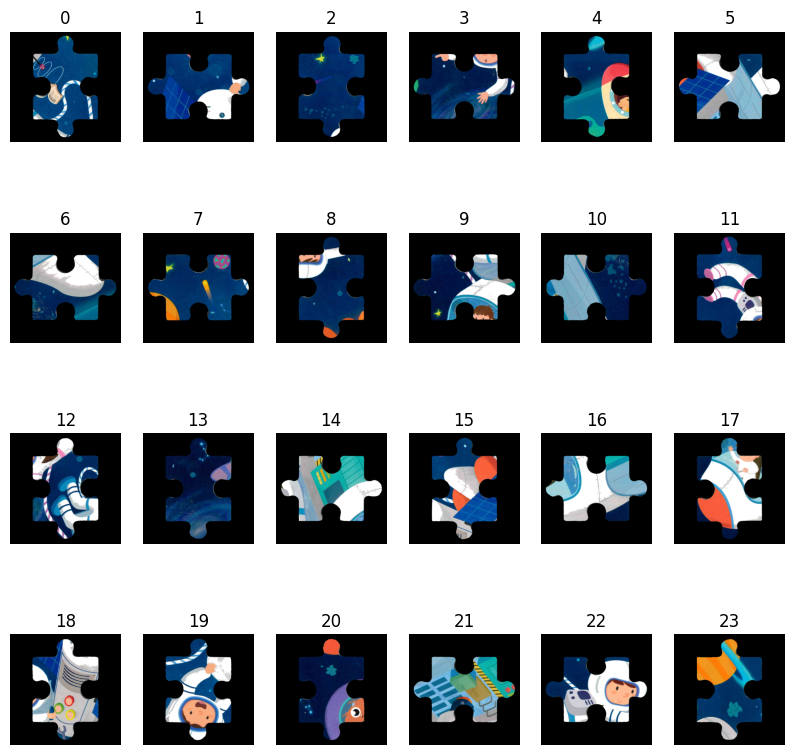

In [106]:
#classification
corner_img =[]
corner_img_white = []

border_type_1_img =  []
border_type_1_img_white = []

border_type_2_img =  []
border_type_2_img_white = []

inner_img = []
inner_img_white = []
for i,tile in  enumerate(tiles_white):
        cnt, _ = cv2.findContours(tile, 0, 1)
        cnt = cnt[0]
        hull = cv2.convexHull(cnt,returnPoints=False)
        defects = cv2.convexityDefects(cnt,hull)
        center, (h,w), angle = cv2.minAreaRect(cnt)

        defect_points = []
        for j in range(defects.shape[0]):
            s,e,f,d = defects[j,0]
            start = tuple(cnt[s][0])
            end = tuple(cnt[e][0])
            far = tuple(cnt[f][0])
            if d > 2000:
                # cv2.circle(tiles[i],far,5,[0,0,255],20)
                defect_points.append(f)
        # print("Puzzle :",i)
        # lock = inner_out_lock_orientations(cnt,defect_points,[center[0],center[1]],tiles[i])
        total_defects = len(defect_points)
        if total_defects  == 3:
            corner_img.append(tiles[i])
            corner_img_white.append(tile)
        elif total_defects  == 4 :
            border_type_1_img.append(tiles[i])
            border_type_1_img_white.append(tile)
        elif total_defects == 5:
            border_type_2_img.append(tiles[i])
            border_type_2_img_white.append(tile)
        elif total_defects == 6:
            inner_img.append(tiles[i])
            inner_img_white.append(tile)


showlist(corner_img,col=4)
showlist(border_type_1_img)
showlist(border_type_2_img)
showlist(inner_img,col=6)

# Matching Compatibility (Find the neighbours)

In [107]:
def match_color(imgA,imgB,colorA,colorB,comparison):
    colorA = np.array(colorA).reshape(-1,2)
    colorB = np.array(colorB).reshape(-1,2)
    colorA = getColors(imgA,colorA)
    colorB = getColors(imgB,colorB)
    colorB = np.flip(colorB,axis=0)
    total_similarity = mse(colorA,colorB)
    return np.round(total_similarity,4)



def multiple_match_puzzle_and_color(selected_puzzles,candidatePuzzle,selectedDatas,candidateDatas,multipleConditions,match_comparison):
    # selected is 1 puzzle and candidate are 4 version of 1 puzzle

    data_comb = []
    color_similarity  = []
    selected_condition = []
    selected_color = []
    mean_similarity = 0
    selected_candidate_puzzle = []
    
    for i,match in enumerate(match_comparison):
        condition = {}    
        for segmentS in selectedDatas[i]:
            condition[dict(segmentS).get('pos')] = dict(segmentS).get('type')
            if dict(segmentS).get('pos') == match[0]:
                selected_color.append(dict(segmentS).get('colour'))
        selected_condition.append(condition)
        

    for l,condition in enumerate(multipleConditions):
        minimum_similarity = 200
        selected_candidate_index = 0
        for j,data in enumerate(candidateDatas):
            candidate_condition = {}
            candidate_color = []    
            for segmentC in data:
                candidate_condition[dict(segmentC).get('pos')] = dict(segmentC).get('type')     
        
            if ((condition[0] == selected_condition[l]) and  (condition[1] == candidate_condition)):
                # showlist([selected_puzzles[l],candidatePuzzle[j]])
                # print(match_comparison[l])
                for segmentC in data:
                    if dict(segmentC).get('pos') == match_comparison[l][1]:
                        candidate_color = dict(segmentC).get('colour')
                similarity = match_color(selected_puzzles[l].copy(),candidatePuzzle[j].copy(),selected_color[l],candidate_color,match_comparison[l])        

                # data_comb = [selected_puzzles[l],candidatePuzzle[j],selectedDatas[l],data]
                
                if similarity < minimum_similarity:
                    selected_candidate_index = j
                    minimum_similarity = similarity
        color_similarity.append(minimum_similarity)
        data_comb.append([candidatePuzzle[selected_candidate_index],candidateDatas[selected_candidate_index]])

    mean_similarity = np.round(np.mean(color_similarity),4)
    if len(data_comb) == 2:
        selected_candidate_puzzle = data_comb[1]
    else: 
        selected_candidate_puzzle = data_comb[0]
    return mean_similarity,selected_candidate_puzzle


def final_best_puzzle(selectedPuzzle,selectedData,candidatePuzzles,candidateWhitePuzzles,condition,matchType):
    color_match = []

    combinations = []
    best_candidate_puzzle = []
    best_candidate_data = []
    
    for k,tile in enumerate(candidatePuzzles):
        candidatePuzzle,candidateWhitePuzzle,candidateData  = rotate_puzzle(tile,candidateWhitePuzzles[k])

        similarity,candidate = multiple_match_puzzle_and_color(selectedPuzzle,candidatePuzzle,selectedData,candidateData,condition,matchType)

        color_match.append(similarity)
        combinations.append(candidate)


    if((len(color_match) !=0) ):
        # print(color_match)
        index = np.argmin(color_match)
        best_candidate_puzzle = combinations[index][0]
        best_candidate_data = combinations[index][1]
        
        candidatePuzzles.pop(index)
        candidateWhitePuzzles.pop(index)
    return best_candidate_puzzle,best_candidate_data


def get_first_top_left_puzzle(corners,corners_white,condition):
    orange_color = []
    for corner in corners:
        hsv = cv2.cvtColor(corner,cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(hsv,(10,100,20),(25,255,255))
        orange_color.append(np.count_nonzero(mask))

    index = np.argmax(orange_color)
    all_rotated_puzzle,all_rotated_white,all_rotated_data  = rotate_puzzle(corners[index],corners_white[index])
    
    for i,data in enumerate(all_rotated_data):
        cond_build = {}
        for segment in data:
            cond_build[dict(segment).get('pos')] = dict(segment).get('type')
        if cond_build == condition:    
            return all_rotated_puzzle[i], data,cond_build


In [108]:
puzzle_template = []
for k in range(1,7):
    row = []
    for l in range (1,9):
        if k %2 == 0:
            if k ==6:
                if l ==1:
                    row.append(('corner',{'TOP':'INNER','RIGHT':'OUTER'}))
                elif l == 8:
                    row.append(('corner',{'LEFT':'INNER','TOP':'OUTER'}))
                elif l % 2 == 0:
                    row.append(('border1',{'TOP':'OUTER','RIGHT':'INNER','LEFT':'INNER'}))
                elif l % 2 != 0:
                    row.append(('border2',{'TOP':'INNER','RIGHT':'OUTER','LEFT':'OUTER'}))
            else:
                if l==1:
                    row.append(('border1',{'TOP':'INNER','RIGHT':'OUTER','BOTTOM':'INNER'}))
                elif l ==8:
                    row.append(('border2',{'TOP':'OUTER','LEFT':'INNER','BOTTOM':'OUTER'}))
                elif l%2 ==0:
                        row.append(('inner',{'TOP':'OUTER','BOTTOM':'OUTER','RIGHT':'INNER','LEFT':'INNER'}))
                elif l%2 != 0:
                        row.append(('inner',{'TOP':'INNER','BOTTOM':'INNER','RIGHT':'OUTER','LEFT':'OUTER'}))
        else:
            if k ==1 :
                if l ==1:
                    row.append(('corner',{'BOTTOM':'OUTER','RIGHT':'INNER'}))
                elif l== 8:
                    row.append(('corner',{'BOTTOM':'INNER','LEFT':'OUTER'}))
                elif l % 2 == 0:
                    row.append(('border2',{'BOTTOM':'INNER','RIGHT':'OUTER','LEFT':'OUTER'}))
                elif l % 2 != 0:
                    row.append(('border1',{'BOTTOM':'OUTER','RIGHT':'INNER','LEFT':'INNER'}))
            else:
                if l==1:
                    row.append(('border2',{'TOP':'OUTER','RIGHT':'INNER','BOTTOM':'OUTER'}))  
                elif l ==8:
                    row.append(('border1',{'TOP':'INNER','LEFT':'OUTER','BOTTOM':'INNER'}))

                elif l%2 ==0:
                        row.append(('inner',{'TOP':'INNER','BOTTOM':'INNER','RIGHT':'OUTER','LEFT':'OUTER'}))
                elif l%2 != 0:
                        row.append(('inner',{'TOP':'OUTER','BOTTOM':'OUTER','RIGHT':'INNER','LEFT':'INNER'}))
    puzzle_template.append(row)


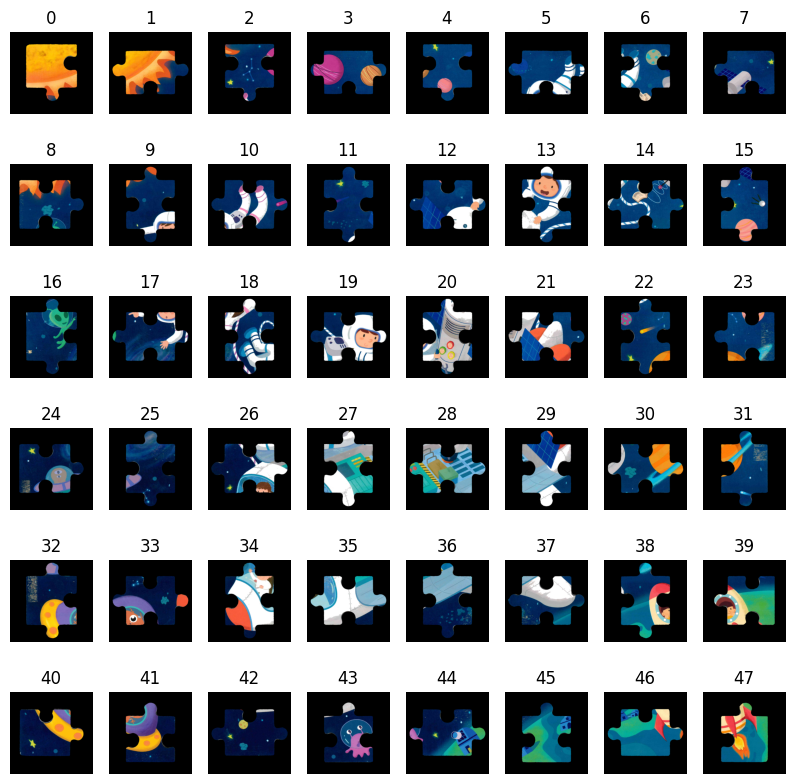

In [109]:
corners = corner_img.copy()
corners_white = corner_img_white.copy()

border1 = border_type_1_img.copy()
border1_white = border_type_1_img_white.copy()

border2 =  border_type_2_img.copy()
border2_white = border_type_2_img_white.copy()

inners = inner_img.copy()
inners_white = inner_img_white.copy()


all_puzzle = []
completed_puzzle = []
for m in range(6):
    conditions = []
    selected_best_puzzle = []
    for n in range(8):
        candidate_puzzle_type = puzzle_template[m][n][0]
        condition = puzzle_template[m][n][1]

        if m==0 and n ==0:

            puzzle_left,data_left,cond =  get_first_top_left_puzzle(corners,corners_white,condition)
            selected_best_puzzle.append([puzzle_left,data_left])
            all_puzzle.append(puzzle_left)

        else:
            data_candidate = []
            data_white_candidate = []
            if candidate_puzzle_type == 'corner':
                data_candidate = corners
                data_white_candidate = corners_white
            elif candidate_puzzle_type == 'border1':
                data_candidate = border1
                data_white_candidate = border1_white
            elif candidate_puzzle_type == 'border2':
                data_candidate = border2
                data_white_candidate = border2_white
            elif candidate_puzzle_type == 'inner':
                data_candidate = inners
                data_white_candidate = inners_white
                
            if m != 0 and n ==0:
                selected_condition = puzzle_template[m-1][0][1]
                selected_puzzle = [completed_puzzle[m-1][0][0]]
                selected_puzzle_data = [completed_puzzle[m-1][0][1]]
                match_comparison = [('BOTTOM','TOP')]
                condition_between_puzzles = [[selected_condition,condition]]
                best_puzzle, best_puzzle_data = final_best_puzzle(selected_puzzle,selected_puzzle_data,data_candidate,data_white_candidate,condition_between_puzzles,match_comparison)               
                   
            elif m == 0 and n !=0:
                selected_condition = puzzle_template[m][n-1][1]
                selected_puzzle = [selected_best_puzzle[-1:][0][0]]
                selected_puzzle_data = [selected_best_puzzle[-1:][0][1]]
                match_comparison = [('RIGHT','LEFT')]
                condition_between_puzzles = [[selected_condition,condition]]
                best_puzzle, best_puzzle_data = final_best_puzzle(selected_puzzle,selected_puzzle_data,data_candidate,data_white_candidate,condition_between_puzzles,match_comparison)
                
            elif m!=0 and n!=0:
                left_condition = puzzle_template[m][n-1][1]
                left_puzzle = selected_best_puzzle[-1:][0][0]
                left_puzzle_data = selected_best_puzzle[-1:][0][1]
                left_match_comparison = ('RIGHT','LEFT')
                 
                top_condition = puzzle_template[m-1][n][1]
                top_puzzle = completed_puzzle[m-1][n][0]
                top_puzzle_data = completed_puzzle[m-1][n][1]
                top_comparison = ('BOTTOM','TOP')
                
                
                puzzle_comparison = [left_puzzle,top_puzzle]
                data_comparison = [left_puzzle_data,top_puzzle_data]
                multiple_match_comparison = [left_match_comparison,top_comparison]
                multiple_condition_comparison = [[left_condition,condition],[top_condition,condition]]

                best_puzzle, best_puzzle_data = final_best_puzzle(puzzle_comparison,data_comparison,data_candidate,data_white_candidate,multiple_condition_comparison,multiple_match_comparison)
            

            selected_best_puzzle.append([best_puzzle, best_puzzle_data])
            all_puzzle.append(best_puzzle)
    completed_puzzle.append(selected_best_puzzle)        
showlistPuzzle(all_puzzle)


# Assembly Puzzle Using Translation
Process:
* Matching based on inner and outer locks' coordinates of neighboring pieces

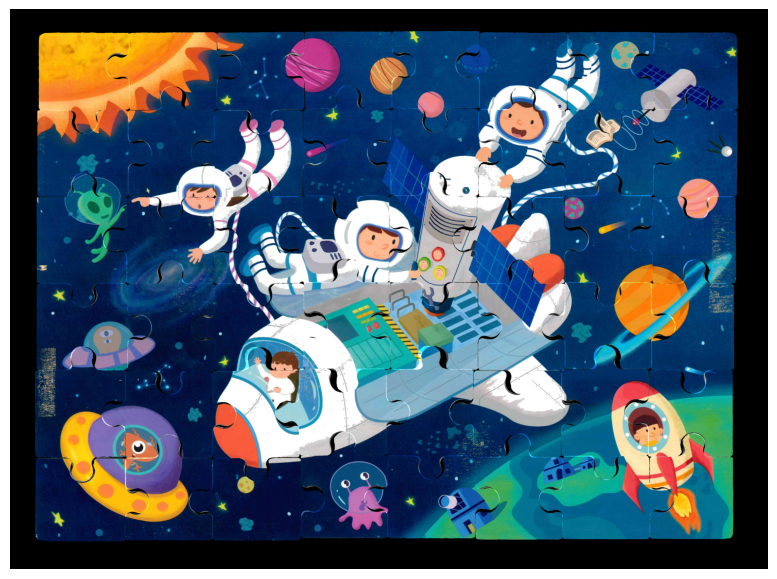

In [110]:
previous_row = []
shift_row = []
for i in range(6):
    previous = []
    shift = []
    for j in range(8):
        
        img_now = np.zeros((5400,7200,3)).astype(np.uint8)
        img_now[i*900:900+i*900,j*900:900+j*900] = completed_puzzle[i][j][0]
        
        if i == 0 and j == 0:
            previous = img_now
            shift.append([0,0])
            
        elif i  == 0 and j != 0:
            right_coordinate = []
            left_coordinate = []
            for data in completed_puzzle[i][j-1][1]:
                if dict(data).get('pos') == 'RIGHT':
                    right_coordinate = dict(data).get('coordinate')
            for data in completed_puzzle[i][j][1]:
                if dict(data).get('pos') == 'LEFT':
                    left_coordinate = dict(data).get('coordinate')
           
            diff_x = (900 - right_coordinate[0]) + left_coordinate[0] + shift[j-1][0]
            diff_y = right_coordinate[1] - left_coordinate[1] + shift[j-1][1]

            M = np.float32([[1, 0, - diff_x],[0, 1, diff_y]])
            shifted = cv2.warpAffine(img_now, M, (img_now.shape[1], img_now.shape[0]))
            merge = cv2.add(previous,shifted)
            previous = merge
            shift.append([diff_x,diff_y])

        elif i != 0 and j == 0:
            bottom_coordinate = []
            top_coordinate = []
            for data in completed_puzzle[i-1][0][1]:
                if dict(data).get('pos') == 'BOTTOM':
                    bottom_coordinate = dict(data).get('coordinate')
            for data in completed_puzzle[i][j][1]:
                if dict(data).get('pos') == 'TOP':
                    top_coordinate = dict(data).get('coordinate')
                    
  
            diff_x = top_coordinate[0] - bottom_coordinate[0] + shift_row[i-1][j][0]
            diff_y = (900 - bottom_coordinate[1]) + top_coordinate[1] + shift_row[i-1][j][1]
            # print(diff_x,diff_y)
            M = np.float32([[1, 0, - diff_x],[0, 1, - diff_y]])
            shifted = cv2.warpAffine(img_now, M, (img_now.shape[1], img_now.shape[0]))
            merge = cv2.add(previous_row,shifted)
            previous = merge
            shift.append([diff_x,diff_y])
        
        elif i!=0 and j !=0:
            right_coordinate = []
            left_coordinate = []
            bottom_coordinate = []
            top_coordinate = []
            
            for data in completed_puzzle[i-1][j][1]:
                if dict(data).get('pos') == 'BOTTOM':
                    bottom_coordinate = dict(data).get('coordinate')
                    
            for data in completed_puzzle[i][j-1][1]:
                if dict(data).get('pos') == 'RIGHT':
                    right_coordinate = dict(data).get('coordinate')
                    
                    
            for data in completed_puzzle[i][j][1]:
                if dict(data).get('pos') == 'TOP':
                    top_coordinate = dict(data).get('coordinate')
                if dict(data).get('pos') == 'LEFT':
                    left_coordinate = dict(data).get('coordinate')
            
            y_shift= shift_row[i-1][j][1] 
            if y_shift > 0 :
                y_shift = -1 * y_shift
            diff_y1 = (900 - bottom_coordinate[1]) + top_coordinate[1] - y_shift
            diff_x2 = (900 - right_coordinate[0]) + left_coordinate[0] + shift[j-1][0]

            M = np.float32([[1, 0, - (diff_x2)],[0, 1, - diff_y1]])
            shifted = cv2.warpAffine(img_now, M, (img_now.shape[1], img_now.shape[0]))
            merge = cv2.add(previous,shifted)
            previous = merge
            shift.append([diff_x2,diff_y1])

    shift_row.append(shift)
    previous_row = merge

showpic(previous_row[:3400,:4600,])



## `Please save all the listed puzzles into Jupyter for the code execution in Part 4.`

In [111]:
%store all_puzzle

Stored 'all_puzzle' (list)
